# Regularizing Linear Models

## Setup

In [2]:
import os
if os.getcwd().endswith("notebooks"):
    os.chdir('..')

print("Current working directory: ", os.getcwd())
if not os.getcwd().endswith("ML-Regression-Notebooks"):
    raise ValueError("Please change working directory to 'path/Classifying-the-MNIST' before proceeding")

Current working directory:  /Users/irellzane/MLprojects/ML-Regression-Notebooks


In [3]:
!pip install -r requirements.txt


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Generate Data

In [5]:
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5

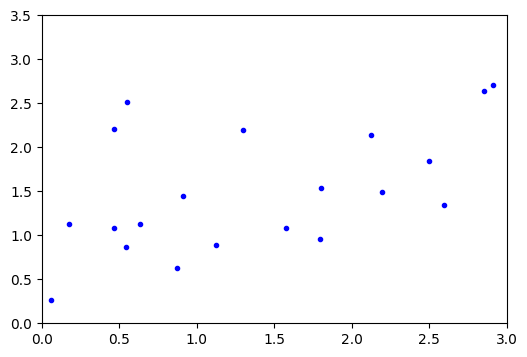

In [6]:
plt.figure(figsize=(6, 4))
plt.axis([0, 3, 0, 3.5])
plt.plot(X, y, "b.")
plt.show()

In [7]:
from modules.plot_model import plot_model
def plot_regressions(model, polynomial, alphas):
    plt.plot(X, y, "b.")
    plot_model(X, y, model, polynomial, alphas, random_state=42)

## Ridge Regression

#### with sklearn

In [8]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=0.1, solver="cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55325833]])

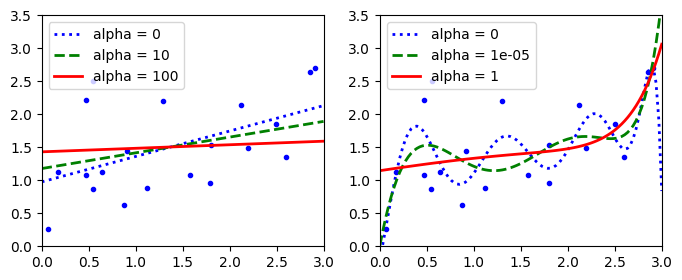

In [9]:
from modules.plot_model import plot_model
plt.figure(figsize=(8, 3))
plt.subplot(121)
plot_regressions(Ridge, polynomial=False, alphas=(0, 10, 100))
plt.subplot(122)
plot_regressions(Ridge, polynomial=True, alphas=(0, 1e-05, 1))

#### With SGDregressor

In [10]:
from sklearn.linear_model import SGDRegressor

sgd_red = SGDRegressor(penalty="l2", alpha=0.1/m, tol=None,
                       max_iter=1000, eta0=0.01, random_state=42)

sgd_red.fit(X, y.ravel())
sgd_red.predict([[1.5]])

array([1.55302613])

## Lasso Regression

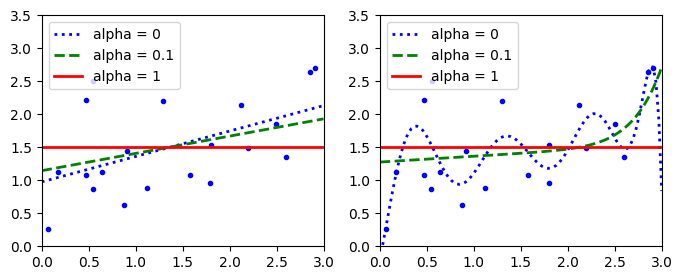

In [11]:
from sklearn.linear_model import Lasso

plt.figure(figsize=(8, 3))
plt.subplot(121)
plot_regressions(Lasso, False, (0, 0.1, 1))
plt.subplot(122)
plot_regressions(Lasso, True, (0, 0.1, 1))
plt.show()

### Lasso vs Ridge

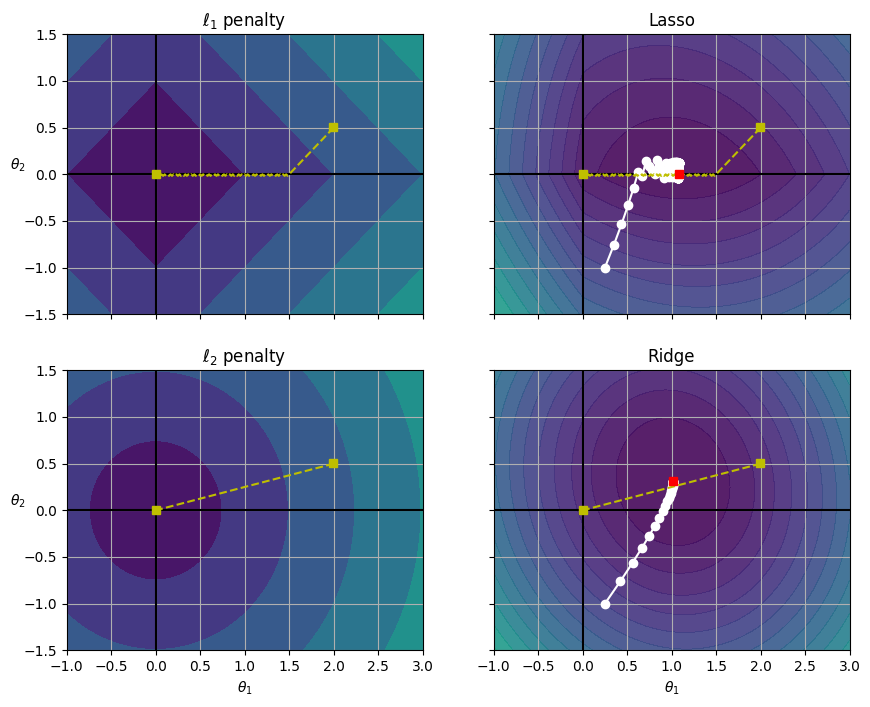

In [15]:
t1a, t1b, t2a, t2b = -1, 3, -1.5, 1.5

t1s = np.linspace(t1a, t1b, 500)
t2s = np.linspace(t2a, t2b, 500)
t1, t2 = np.meshgrid(t1s, t2s)
T = np.c_[t1.ravel(), t2.ravel()]
Xr = np.array([[1, 1], [1, -1], [1, 0.5]])
yr = 2 * Xr[:, :1] + 0.5 * Xr[:, 1:]

J = (1 / len(Xr) * ((T @ Xr.T - yr.T) ** 2).sum(axis=1)).reshape(t1.shape)

N1 = np.linalg.norm(T, ord=1, axis=1).reshape(t1.shape)
N2 = np.linalg.norm(T, ord=2, axis=1).reshape(t1.shape)

t_min_idx = np.unravel_index(J.argmin(), J.shape)
t1_min, t2_min = t1[t_min_idx], t2[t_min_idx]

t_init = np.array([[0.25], [-1]])

def bgd_path(theta, X, y, l1, l2, core=1, eta=0.05, n_iterations=200):
    path = [theta]
    for iteration in range(n_iterations):
        gradients = (core * 2 / len(X) * X.T @ (X @ theta - y)
                     + l1 * np.sign(theta) + l2 * theta)
        theta = theta - eta * gradients
        path.append(theta)
    return np.array(path)

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10.1, 8))

for i, N, l1, l2, title in ((0, N1, 2.0, 0, "Lasso"), (1, N2, 0, 2.0, "Ridge")):
    JR = J + l1 * N1 + l2 * 0.5 * N2 ** 2

    tr_min_idx = np.unravel_index(JR.argmin(), JR.shape)
    t1r_min, t2r_min = t1[tr_min_idx], t2[tr_min_idx]

    levels = np.exp(np.linspace(0, 1, 20)) - 1
    levelsJ = levels * (J.max() - J.min()) + J.min()
    levelsJR = levels * (JR.max() - JR.min()) + JR.min()
    levelsN = np.linspace(0, N.max(), 10)

    path_J = bgd_path(t_init, Xr, yr, l1=0, l2=0)
    path_JR = bgd_path(t_init, Xr, yr, l1, l2)
    path_N = bgd_path(theta=np.array([[2.0], [0.5]]), X=Xr, y=yr,
                      l1=np.sign(l1) / 3, l2=np.sign(l2), core=0)
    ax = axes[i, 0]
    ax.grid()
    ax.axhline(y=0, color="k")
    ax.axvline(x=0, color="k")
    ax.contourf(t1, t2, N / 2.0, levels=levelsN)
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.set_title(fr"$\ell_{i + 1}$ penalty")
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$")
    ax.set_ylabel(r"$\theta_2$", rotation=0)

    ax = axes[i, 1]
    ax.grid()
    ax.axhline(y=0, color="k")
    ax.axvline(x=0, color="k")
    ax.contourf(t1, t2, JR, levels=levelsJR, alpha=0.9)
    ax.plot(path_JR[:, 0], path_JR[:, 1], "w-o")
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.plot(t1r_min, t2r_min, "rs")
    ax.set_title(title)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$")

plt.show()

## Elastic Net

In [12]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)

ElasticNet(alpha=0.1)

In [13]:
elastic_net.predict([[1.5]])

array([1.54333232])

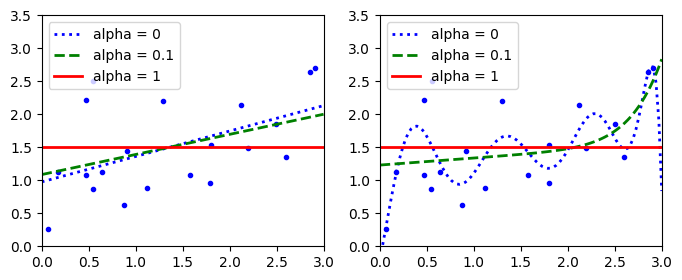

In [13]:
plt.figure(figsize=(8, 3))
plt.subplot(121)
plot_regressions(ElasticNet, polynomial=False, alphas=(0, 0.1, 1))
plt.subplot(122)
plot_regressions(ElasticNet, polynomial=True, alphas=(0, 0.1, 1))
plt.show()